# Movie Classification

* https://machinelearninggeek.com/latent-dirichlet-allocation-using-scikit-learn/
* https://www.kaggle.com/rajmehra03/topic-modelling-using-lda-and-lsa-in-sklearn
* https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/#17howtofindtheoptimalnumberoftopicsforlda
* https://medium.com/swlh/topic-modeling-lda-mallet-implementation-in-python-part-2-602ffb38d396
* https://towardsdatascience.com/evaluate-topic-model-in-python-latent-dirichlet-allocation-lda-7d57484bb5d0
* https://colab.research.google.com/drive/1NWj4ioKmqtC1xQkC6opATdGZc27Z9miL

In [59]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 1. Web Scrapping

ทำการ Scrape โดยเลือกประเภทหนังเป็น Feature Film ในประเทศอเมริกา ตั้งแต่ปี 2018 ถึง 2021

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import warnings
sns.set(style='whitegrid', palette="deep", rc={"figure.figsize": [8, 5]})
%matplotlib inline
warnings.filterwarnings('ignore')

In [ ]:
from requests import get
from bs4 import BeautifulSoup

page_movie = []

for i in [2018, 2019, 2020, 2021]:
    for j in range(1, 4200, 100):
        url = "https://www.imdb.com/search/title/?title_type=feature&release_date="+str(i)+"-01-01,"+str(i)+"-12-31&countries=us&sort=alpha,asc&count=100&start="+str(j)+"&ref_=adv_nxt"
        response = get(url)
        html_soup = BeautifulSoup(response.text, 'html.parser')
        movie_containers = html_soup.find_all('div', class_ = 'lister-item mode-advanced')

        names = []
        years = []
        genres = []
        descriptions = []

        for container in movie_containers:

            if (container.find('span', attrs = {'class': 'genre'}) is not None) and ((container.find_all('p', attrs={'class':'text-muted'})[-1].text) != '\nAdd a Plot\n'):

                name = container.h3.a.text
                names.append(name)

                year = container.h3.find('span', class_ = 'lister-item-year').text
                years.append(year)

                genre = container.find('span', attrs = {'class': 'genre'}).text
                genres.append(genre)

                description = container.find_all('p', attrs={'class':'text-muted'})[-1].text
                descriptions.append(description)
        test_df = pd.DataFrame({'movie': names,
                                'year': years,
                                'genres': genres,
                                'descriptions': descriptions})
        page_movie.append(test_df)

df = pd.concat(page_movie).reset_index(drop=True)

In [ ]:
# import pickle
# # df.to_pickle('df.pickle')
# df = pd.read_pickle('df.pickle')
# df.head(10)

In [ ]:
# df.to_excel('df.xlsx', index=False)

In [282]:
df = pd.read_excel('/content/drive/MyDrive/MSDS/Movie Genre Classification/df.xlsx')
df.head()

,movie,year,genres,descriptions
0,#1915House,(2018),"\nHorror, Thriller",\nA century of secrets are hidden behind the f...
1,#SquadGoals,(2018),"\nDrama, Thriller","\nSamantha is a serious journalist, both for t..."
2,#Victoria,(2018),"\nAction, Drama",\nVictoria moves from out of town into the poo...
3,1 Angry Black Man,(2018),\nDrama,\nMike Anderson is a senior at the quintessent...
4,"1 Dead man, 6 Suspects, $65 Million",(2018),\nMystery,"\nA low budget but slick ""who done it"" involvi..."


## 2. Data Preparation

In [3]:
df.year.unique()

array(['(2018)', '(I) (2018)', nan, '(II) (2018)', '(III) (2018)',
       '(IV) (2018)', '(V) (2018)', '(IX) (2018)', '(XXIII)',
       '(VI) (2018)', '(VIII) (2018)', '(2019)', '(VII)',
       '(XVIII) (2018)', '(I)', '(II)', '(XVI) (2018)', '(II) (2019)',
       '(I) (2019)', '(IV) (2019)', '(V) (2019)', '(III) (2019)',
       '(VI) (2019)', '(VIII) (2019)', '(XXXV) (2019)', '(VII) (2019)',
       '(X) (2019)', '(IX) (2019)', '(XII) (2019)', '(2020)',
       '(III) (2020)', '(II) (2020)', '(I) (2020)', '(XXI) (2020)',
       '(V) (2020)', '(VI) (2020)', '(IV) (2020)', '(2021)',
       '(VIII) (2020)', '(XI) (2020)', '(I) (2021)', '(II) (2021)',
       '(IV) (2021)', '(XII) (2021)', '(III) (2021)', '(VI) (2021)',
       '(V) (2021)', '(VI)'], dtype=object)

In [283]:
df.year = df.year.str.extract('(\d+)')
df.year = df.year.ffill(axis = 0)
df.year.unique()

array(['2018', '2019', '2020', '2021'], dtype=object)

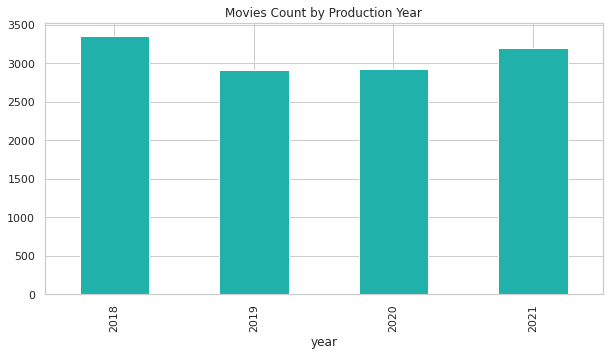

In [5]:
df.groupby(['year']).size().plot(kind='bar', color={'#20B2AA'}, figsize=(10,5), title='Movies Count by Production Year')

In [284]:
df.genres = df.genres.str.strip()
df.head()

,movie,year,genres,descriptions
0,#1915House,2018,"Horror, Thriller",\nA century of secrets are hidden behind the f...
1,#SquadGoals,2018,"Drama, Thriller","\nSamantha is a serious journalist, both for t..."
2,#Victoria,2018,"Action, Drama",\nVictoria moves from out of town into the poo...
3,1 Angry Black Man,2018,Drama,\nMike Anderson is a senior at the quintessent...
4,"1 Dead man, 6 Suspects, $65 Million",2018,Mystery,"\nA low budget but slick ""who done it"" involvi..."


In [36]:
# set(df.genres.tolist())

In [285]:
genres = df.genres.tolist()
genres = ", ".join(genres)
genres = sorted(list(set(genres.split(", "))))
genres


['Action',
 'Adventure',
 'Animation',
 'Biography',
 'Comedy',
 'Crime',
 'Drama',
 'Family',
 'Fantasy',
 'Game-Show',
 'History',
 'Horror',
 'Music',
 'Musical',
 'Mystery',
 'News',
 'Reality-TV',
 'Romance',
 'Sci-Fi',
 'Sport',
 'Talk-Show',
 'Thriller',
 'War',
 'Western']

In [286]:
for g in genres:
  df[g] = df["genres"].apply(lambda x: 1 if len(set(x.split(", ")).intersection(set([g]))) > 0 else 0)
df.head()

,movie,year,genres,descriptions,Action,Adventure,Animation,Biography,Comedy,Crime,Drama,Family,Fantasy,Game-Show,History,Horror,Music,Musical,Mystery,News,Reality-TV,Romance,Sci-Fi,Sport,Talk-Show,Thriller,War,Western
0,#1915House,2018,"Horror, Thriller",\nA century of secrets are hidden behind the f...,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0
1,#SquadGoals,2018,"Drama, Thriller","\nSamantha is a serious journalist, both for t...",0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2,#Victoria,2018,"Action, Drama",\nVictoria moves from out of town into the poo...,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,1 Angry Black Man,2018,Drama,\nMike Anderson is a senior at the quintessent...,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,"1 Dead man, 6 Suspects, $65 Million",2018,Mystery,"\nA low budget but slick ""who done it"" involvi...",0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0


In [174]:
df.shape

(12388, 28)

In [107]:
df.isnull().any()

movie           False
year            False
genres          False
descriptions    False
Action          False
Adventure       False
Animation       False
Biography       False
Comedy          False
Crime           False
Drama           False
Family          False
Fantasy         False
Game-Show       False
History         False
Horror          False
Music           False
Musical         False
Mystery         False
News            False
Reality-TV      False
Romance         False
Sci-Fi          False
Sport           False
Talk-Show       False
Thriller        False
War             False
Western         False
dtype: bool

In [108]:
df.loc[:, genres].sum().sort_values(ascending=False)

Drama         5177
Comedy        3046
Horror        2339
Thriller      2171
Action        1420
Crime          937
Romance        834
Adventure      777
Mystery        714
Sci-Fi         698
Family         569
Animation      503
Fantasy        490
Biography      240
Music          215
Musical        170
Western        150
History        148
Sport          110
War             84
Reality-TV      19
Talk-Show       16
News             7
Game-Show        1
dtype: int64

In [287]:
#เลือก column 10 genres ที่มีมากที่สุด
df = df[['movie', 'year', 'genres', 'descriptions', 'Drama', 'Comedy', 'Horror', 'Thriller', 'Action', 'Crime', 'Romance', 'Adventure', 'Mystery', 'Sci-Fi']]
df.shape

(12388, 14)

In [288]:
index_names = df[(df['Drama']==0)&(df['Comedy']==0)&(df['Horror']==0)&(df['Thriller']==0)&(df['Action']==0)&(df['Crime']==0)&(df['Romance']==0)&(df['Adventure']==0)&(df['Mystery']==0)&(df['Sci-Fi']==0)].index
index_names

Int64Index([   50,    52,    55,    65,    67,    91,    95,   103,   115,
              155,
            ...
            12268, 12297, 12305, 12326, 12330, 12347, 12350, 12370, 12374,
            12382],
           dtype='int64', length=912)

In [289]:
df = df.drop(index_names)
df.tail(10)

,movie,year,genres,descriptions,Drama,Comedy,Horror,Thriller,Action,Crime,Romance,Adventure,Mystery,Sci-Fi
12377,Zed's Dead,2021,Adventure,\nTake a plunge into the morbid world of Z and...,0,0,0,0,0,0,0,1,0,0
12378,Zero Avenue,2021,"Horror, Romance","\nJoshua, a reluctant immortal, plans to end h...",0,0,1,0,0,0,1,0,0,0
12379,Zero Contact,2021,Thriller,\nProduced in 17 different countries entirely ...,0,0,0,1,0,0,0,0,0,0
12380,Zeros and Ones,2021,"Thriller, War",\nAn American soldier stationed in Rome with t...,0,0,0,1,0,0,0,0,0,0
12381,Zidane Adams: The Black Blogger!,2021,Drama,"\nThe life of a cynical, black blogger, former...",1,0,0,0,0,0,0,0,0,0
12383,Zone Drifter,2021,Sci-Fi,"\nIn the distant future, a former soldier batt...",0,0,0,0,0,0,0,0,0,1
12384,Zooey,2021,"Comedy, Drama, Sci-Fi","\nWhen a young boy, Noah, meets Zooey, a young...",1,1,0,0,0,0,0,0,0,1
12385,Zwtral,2021,Mystery,\nMaking trades is his life. Justin finds hims...,0,0,0,0,0,0,0,0,1,0
12386,d'ILLUSION: The Houdini Musical,2021,"Biography, Drama, Musical",\nThe University of Cincinnati - College-Conse...,1,0,0,0,0,0,0,0,0,0
12387,iGilbert,2021,Drama,"\nGilbert Gonzalez (Adrian Martinez), feels is...",1,0,0,0,0,0,0,0,0,0


In [290]:
df.shape

(11476, 14)

In [291]:
df.descriptions.tolist()[:20]

["\nA century of secrets are hidden behind the fresh paint and modern additions. Peeling back the layers is letting something escape, and he might not see it till it's too late.",
 "\nSamantha is a serious journalist, both for the school paper and for the yearbook, but she's just as serious about her friends, Nate, Gillian, and Rudy, all of whom are vying with her for a full-ride local scholarship to college.",
 '\nVictoria moves from out of town into the poor inner city of New York with her father, the neighborhood drug dealer. She goes on a journey, seeking answers, justice, and revenge after her ...                See full summary\xa0»\n',
 '\nMike Anderson is a senior at the quintessential New-England liberal arts school, Frost College. And Mike is eight weeks away from graduation. On this particular day he has his ...                See full summary\xa0»\n',
 '\nA low budget but slick "who done it" involving the murder of a wealthy businessman. The long list of suspects includes t

In [293]:
import re
df.corpus = df.descriptions.str.strip()
df.corpus = df.corpus.str.replace('...                See full summary\xa0»', '', regex=True)
df.corpus = df.corpus.str.lower()
df.corpus = df.corpus.map(lambda x: re.sub("what's", 'what is', x))
df.corpus = df.corpus.map(lambda x: re.sub("'s", '', x))
df.corpus = df.corpus.map(lambda x: re.sub("'ve", ' have', x))
df.corpus = df.corpus.map(lambda x: re.sub("'re", ' are', x))
df.corpus = df.corpus.map(lambda x: re.sub("can't", 'can not', x))
df.corpus = df.corpus.map(lambda x: re.sub("n't", ' not', x))
df.corpus = df.corpus.map(lambda x: re.sub("'ll", ' will', x))
df.corpus = df.corpus.map(lambda x: re.sub("[,\/.!?():;$%&*@#^+=~_{}<>`]", '', x))
df.corpus = df.corpus.str.replace('"', '', regex=True)

In [294]:
import nltk
from nltk.stem.porter import *
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import *
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [295]:
def stopword_removal(x, stpws=stopwords.words("english")):
  return list(set(x).difference(set(stpws)))

def lemmatization(x, stemmer=PorterStemmer()):
  return [stemmer.stem(i) for i in x]

def number_removal(x):
  return [i for i in x if not i.isnumeric()]

df.corpus = df.corpus.apply(lambda x: word_tokenize(x))
df.corpus = df.corpus.apply(lambda x: stopword_removal(x))
df.corpus = df.corpus.apply(lambda x: lemmatization(x))
df.corpus = df.corpus.apply(lambda x: number_removal(x))
df.corpus = df.corpus.apply(lambda x: " ".join(x))
df.corpus.tolist()[0:20]

['let back paint centuri someth might late see layer escap behind fresh till hidden modern peel addit secret',
 'gillian local friend yearbook nate scholarship full-rid colleg paper school vy rudi seriou samantha journalist',
 'dealer victoria justic drug neighborhood inner journey answer move father citi york poor goe town reveng seek new',
 'liber mike away eight particular anderson new-england week senior colleg quintessenti art school frost graduat day',
 'low suspect butler assort slick shadi wealthi done includ greedi famili businessman list involv long murder budget attorney',
 'old year lissa pregnant mayb life revis',
 'realiz friend problem group go detox face island togeth struggl',
 'intellig parallel mysteri live version other man spi whim scientist three shift artist',
 'parti ralphi black partnerlov panther valdez morri compromis jame hunt feder brother undercov member nypd younger status111 detect',
 'special stori taliban take leadership deploy captain strong new afgha

## Splitting Dataset

In [296]:
from sklearn.model_selection import train_test_split
y = df.iloc[:, 4::]
X_train, X_test, y_train, y_test = train_test_split(df.corpus, y, test_size=0.2, random_state=42)
print('X_train size: {}, X_test size: {}'.format(X_train.shape, X_test.shape))

X_train size: (9180,), X_test size: (2296,)


## TFIDF Vetorization

In [297]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(max_features=10000)

X_train_tfidf = vectorizer.fit_transform(X_train)
X_train_tfidf = X_train_tfidf.toarray()

X_test_tfidf = vectorizer.transform(X_test)
X_test_tfidf = X_test_tfidf.toarray()

In [298]:
print('X_train_tfidf size: {}, X_test_tfidf size: {}'.format(X_train_tfidf.shape, X_test_tfidf.shape))

X_train_tfidf size: (9180, 10000), X_test_tfidf size: (2296, 10000)


## Classification without LDA

In [302]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import f1_score, classification_report

### Naive Bayes

In [300]:
nb = OneVsRestClassifier(GaussianNB())
nb.fit(X_train_tfidf, y_train)

OneVsRestClassifier(estimator=GaussianNB(priors=None, var_smoothing=1e-09),
                    n_jobs=None)

In [301]:
y_pred_nb = nb.predict(X_test_tfidf)
print('F1-score of Naive Bayes: ' + str(round(f1_score(y_test, y_pred_nb, average='micro')*100, 2)) + '%')

F1-score of Naive Bayes: 37.26%


In [306]:
mnb = OneVsRestClassifier(MultinomialNB())
mnb.fit(X_train_tfidf, y_train)

OneVsRestClassifier(estimator=MultinomialNB(alpha=1.0, class_prior=None,
                                            fit_prior=True),
                    n_jobs=None)

In [304]:
y_pred_mnb = mnb.predict(X_test_tfidf)
print('F1-score of Naive Bayes: ' + str(round(f1_score(y_test, y_pred_mnb, average='micro')*100, 2)) + '%')

F1-score of Naive Bayes: 27.16%


### Logistic Regression

In [ ]:
lr = OneVsRestClassifier(LogisticRegression(random_state=42))
lr.fit(X_train_tfidf, y_train)
y_pred_lr = lr.predict(X_test_tfidf)
print('F1-score Logistric Regression: ' + str(round(f1_score(y_test, y_pred_lr, average='micro')*100, 2)) + '%')

### K-Nearest Neighobr

In [ ]:
knn = KNeighborsClassifier()
knn.fit(X_train_tfidf, y_train)
y_pred_knn = knn.predict(X_test_tfidf)
print('F1-score K-Nearest Neighbour: ' + str(round(f1_score(y_test, y_pred_knn, average='micro')*100, 2)) + '%')

### Support Vector Machine

In [ ]:
svc = OneVsRestClassifier(SVC())
svc.fit(X_train_tfidf, y_train)
y_pred_svc = svc.predict(X_test_tfidf)
print('F1-score Support Vector Machine: ' + str(round(f1_score(y_test, y_pred_svc, average='micro')*100, 2)) + '%')

### Decision Tree

In [ ]:
dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train_tfidf, y_train)
y_pred_dt = dt.predict(X_test_tfidf)
print('F1-score Decistion Tree: ' + str(round(f1_score(y_test, y_pred_dt, average='micro')*100, 2)) + '%')

### Random Forest

In [ ]:
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train_tfidf, y_train)
y_pred_rf = rf.predict(X_test_tfidf)
print('F1-score: ' + str(round(f1_score(y_test, y_pred_rf, average='micro')*100, 2)) + '%')

### XGBoost

In [ ]:
xgb = OneVsRestClassifier(XGBClassifier(random_state=42, eval_metric='mlogloss'))
xgb.fit(X_train_tfidf, y_train)
y_pred_xgb = xgb.predict(X_test_tfidf)
print('F1-score: ' + str(round(f1_score(y_test, y_pred_xgb, average='micro')*100, 2)) + '%')

## Classification with LDA

In [ ]:
from sklearn.decomposition import LatentDirichletAllocation

#สร้าง model LDA โดยกำหนดจำนวน topics = 20
lda = LatentDirichletAllocation(n_components=20, random_state=42)

#Fit และ Transform
X_train_lda = lda.fit_transform(X_train_tfidf)
X_test_lda = lda.transform(X_test_tfidf)

lda_components = lda.components_
terms = vectorizer.get_feature_names()

for index, component in enumerate(lda_components):
    zipped = zip(terms, component)
    top_terms_key = sorted(zipped, key=lambda t: t[1], reverse=True)[:7]
    top_terms_list = list(dict(top_terms_key).keys())
    print("Topic "+str(index+1)+": ", top_terms_list)

In [ ]:
nb_lda = OneVsRestClassifier(GaussianNB())
nb_lda.fit(X_train_lda, y_train)
y_pred_nb_lda = nb_lda.predict(X_test_lda)
sc_nb_lda = f1_score(y_test, y_pred_nb_lda, average='micro')
print('F1-score of Naive Bayes with LDA: ' + str(round(sc_nb_lda*100, 2)) + '%')

In [ ]:
lr_lda = OneVsRestClassifier(LogisticRegression(random_state=42))
lr_lda.fit(X_train_lda, y_train)
y_pred_lr_lda = lr_lda.predict(X_test_lda)
sc_lr_lda = f1_score(y_test, y_pred_lr_lda, average='micro')
print('F1-score of Logistic Regression with LDA: ' + str(round(sc_lr_lda*100, 2)) + '%')

In [ ]:
knn_lda = KNeighborsClassifier()
knn_lda.fit(X_train_lda, y_train)
y_pred_knn_lda = knn_lda.predict(X_test_lda)
sc_knn_lda = f1_score(y_test, y_pred_knn_lda, average='micro')
print('F1-score of K-Nearest Neighbor with LDA: ' + str(round(sc_knn_lda*100, 2)) + '%')

In [ ]:
#svm

In [ ]:
dt_lda = DecisionTreeClassifier(random_state=42)
dt_lda.fit(X_train_lda, y_train)
y_pred_dt_lda = dt_lda.predict(X_test_lda)
sc_dt_lda = f1_score(y_test, y_pred_dt_lda, average='micro')
print('F1-score of Decision Tree with LDA: ' + str(round(sc_dt_lda*100, 2)) + '%')

In [ ]:
rf_lda = RandomForestClassifier(random_state=42)
rf_lda.fit(X_train_lda, y_train)
y_pred_rf_lda = rf_lda.predict(X_test_lda)
sc_rf_lda = f1_score(y_test, y_pred_rf_lda, average='micro')
print('F1-score of Random Forest with LDA: ' + str(round(sc_rf_lda*100, 2)) + '%')

In [ ]:
xgb_lda = XGBClassifier(random_state=42, eval_metric='mlogloss')
xgb_lda = OneVsRestClassifier(xgb_lda)
xgb_lda.fit(X_train_lda, y_train)
y_pred_xgb_lda = xgb_lda.predict(X_test_lda)
sc_xgb_lda = f1_score(y_test, y_pred_xgb_lda, average='micro')
print('F1-score of XGBoost with LDA: ' + str(round(sc_xgb_lda*100, 2)) + '%')

In [ ]:
f1 = []
for i in range(X_test.shape[0]):
  f1.append(f1_score(y_test[i], y_pred_xgb_lda[i]))
f1
#หา sentence ทั้งหมดที่ทำนายผิด หรือถูก เพื่อดูรูปแบบ text